_한국어로 기계번역됨_



# 단계별 절차 만들기

!!! 정보 "전제 조건"
    이 가이드는 다음에 대한 친숙성을 가정합니다:

    - [그래프 상태 정의 및 업데이트 방법](../../how-tos/state-reducers)

이 가이드는 간단한 단계의 시퀀스를 구성하는 방법을 보여줍니다. 우리는 다음을 시연할 것입니다:

1. 순차 그래프 구축 방법
2. 유사한 그래프를 구성하기 위한 내장 단축키.


# 요약

노드 시퀀스를 추가하기 위해 우리는 [그래프](../../concepts/low_level/#stategraph)의 `.add_node` 및 `.add_edge` 메소드를 사용합니다:
```python
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# 엣지 추가
graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")
```

우리는 내장된 단축키인 `.add_sequence`를 사용할 수도 있습니다:
```python
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")
```


<details>
<summary>LangGraph로 애플리케이션 단계를 시퀀스로 분할하는 이유는 무엇인가요?</summary>

LangGraph는 애플리케이션에 기본적인 지속성 레이어를 추가하는 것을 쉽게 만듭니다.
이는 노드를 실행하는 동안 상태를 체크포인트할 수 있게 하여 LangGraph 노드가 다음을 관리하도록 하니다:

<ul>
<li>상태 업데이트가 [체크포인트](../../concepts/persistence/)되는 방법</li>
<li>중단을 [인간-참여](../../concepts/human_in_the_loop/) 워크플로에서 재개하는 방법</li>
<li>LangGraph의 [타임 트래블](../../concepts/time-travel/) 기능을 사용하여 실행을 "되감기" 및 분기하는 방법</li>
</ul>

또한 실행 단계가 [스트리밍](../../concepts/streaming/)되는 방법과 애플리케이션이 [LangGraph Studio](../../concepts/langgraph_studio/)를 사용하여 시각화되고 디버그되는 방법을 결정합니다.

</details>

## 설정

먼저, langgraph를 설치해봅시다:


In [1]:
%%capture --no-stderr
%pip install -U langgraph


<div class="admonition tip">
     <p class="admonition-title">더 나은 디버깅을 위해 <a href="https://smith.langchain.com">LangSmith</a> 설정하기</p>
     <p style="padding-top: 5px;">
         LangSmith에 가입하여 문제를 신속하게 발견하고 LangGraph 프로젝트의 성능을 개선하세요. LangSmith는 LangGraph로 구축된 LLM 앱을 디버그하고 테스트하며 모니터링하기 위해 추적 데이터를 사용할 수 있게 해줍니다 — 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">문서</a>를 읽어보세요. 
     </p>
 </div>


## 그래프 작성하기

간단한 사용 예제를 보여드리겠습니다. 우리는 세 단계의 순서를 생성할 것입니다:

1. 상태의 키에 값을 채우기
2. 같은 값 업데이트하기
3. 다른 값 채우기

### 상태 정의

먼저 우리의 [상태](../../concepts/low_level/#state)를 정의합시다. 이는 [그래프의 스키마](../../concepts/low_level/#schema)를 결정하며, 업데이트를 적용하는 방법도 지정할 수 있습니다. 자세한 내용은 [이 가이드](../../how-tos/state-reducers)를 참조하세요.

우리 경우에는 두 개의 값만 추적할 것입니다:


In [1]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int


### 노드 정의

우리의 [노드](../../concepts/low_level/#nodes)는 그래프의 상태를 읽고 이를 업데이트하는 파이썬 함수입니다. 이 함수의 첫 번째 인자는 항상 상태가 됩니다:


In [2]:
def step_1(state: State):
    return {"value_1": "a"}


def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}


def step_3(state: State):
    return {"value_2": 10}


!!! 주의

    상태 업데이트를 발행할 때, 각 노드는 업데이트하고자 하는 키의 값을 지정하기만 하면 됩니다.

기본적으로, 이는 해당 키의 값을 **덮어씁니다**. 또한 [리듀서](../../concepts/low_level/#reducers)를 사용하여 업데이트가 처리되는 방식을 제어할 수 있습니다. 예를 들어, 대신 키에 연속적인 업데이트를 추가할 수 있습니다. 자세한 내용은 [이 가이드](../../how-tos/state-reducers)를 참조하십시오.

### 그래프 정의하기

우리는 [StateGraph](../../concepts/low_level/#stategraph)를 사용하여 이 상태에서 작동하는 그래프를 정의합니다.

그런 다음 [add_node](../../concepts/low_level/#messagesstate) 및 [add_edge](../../concepts/low_level/#edges)를 사용하여 그래프를 채우고 제어 흐름을 정의할 것입니다.


In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# Add edges
graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")


!!! 팁 "사용자 지정 이름 지정하기"

    `.add_node`를 사용하여 노드에 대한 사용자 지정 이름을 지정할 수 있습니다:

    ```python
    graph_builder.add_node("my_node", step_1)
    ```


다음 사항에 유의하십시오:

- `.add_edge`는 노드의 이름을 사용합니다. 함수의 경우 기본값은 `node.__name__`입니다.
- 그래프의 진입점을 지정해야 합니다. 이를 위해 [START 노드](../../concepts/low_level/#start-node)와 엣지를 추가합니다.
- 더 이상 실행할 노드가 없으면 그래프는 멈춥니다.

다음으로 그래프를 [컴파일](../../concepts/low_level/#compiling-your-graph)합니다. 이는 그래프 구조에 대한 몇 가지 기본 검사를 수행합니다(예: 고아 노드 식별). 응용 프로그램에 [체크포인터](../../concepts/persistence/)를 통해 지속성을 추가하는 경우, 여기에도 전달됩니다.


In [4]:
graph = graph_builder.compile()


LangGraph는 그래프를 시각화하기 위한 내장 유틸리티를 제공합니다. 우리의 시퀀스를 살펴보겠습니다. 시각화에 대한 자세한 내용은 [이 가이드](../../how-tos/visualization)를 참조하세요.


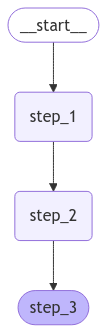

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


### 사용법

간단한 호출로 진행해 보겠습니다:


In [6]:
graph.invoke({"value_1": "c"})


{'value_1': 'a b', 'value_2': 10}

다음과 같은 사항에 유의하십시오:

- 단일 상태 키에 대한 값을 제공하여 호출을 시작했습니다. 항상 최소한 하나의 키에 대한 값을 제공해야 합니다.
- 우리가 전달한 값은 첫 번째 노드에 의해 덮어씌워졌습니다.
- 두 번째 노드가 값을 업데이트했습니다.
- 세 번째 노드는 다른 값을 채웠습니다.


## 내장 약어

!!! 정보 "전제 조건"
    `.add_sequence`는 `langgraph>=0.2.46`가 필요합니다.

LangGraph는 편의를 위해 내장된 약어 `.add_sequence`를 포함합니다:


In [7]:
# highlight-next-line
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})


{'value_1': 'a b', 'value_2': 10}